In [13]:
import itertools
import numpy as np
import random
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow.contrib.slim as slim
import matplotlib.pyplot as plt
import scipy.misc
import os

from game import *
from random import randint
import networkx as nx

In [14]:
rules = Rules()
rules.nb_max_step = 100
rules.nb_players = 10

game1 = Game()
game1.rules = rules

player1 = Player()
player1.rules = rules
player1.type = EntityType.competitive_player

game1.add_player(player1)

game1.initialize_graph()

def get_game_graph(game):
    return np.float32(nx.adjacency_matrix(game.graph).todense())

def get_actions(game):
    return list(itertools.combinations(list(game.players.keys()), 2))

def get_action_space(game):
    actions = get_actions(game)
    return len(actions)

def get_input_space(game):
    return game.rules.nb_players**2

tf.reset_default_graph()
#These lines establish the feed-forward part of the network used to choose actions
action_space = get_action_space(game1)
input_space = get_input_space(game1)

inputs1 = tf.placeholder(shape=[1,input_space],dtype=tf.float32)
W = tf.Variable(tf.random_uniform([input_space, action_space],0,0.01))
b = tf.Variable(tf.zeros([action_space]))
Qout = tf.matmul(inputs1,W) + b
predict = tf.argmax(Qout,1)

#Below we obtain the loss by taking the sum of squares difference between the target and prediction Q values.
nextQ = tf.placeholder(shape=[1,action_space],dtype=tf.float32)
loss = tf.reduce_sum(tf.square(nextQ - Qout))
trainer = tf.train.AdamOptimizer(learning_rate=0.001)
updateModel = trainer.minimize(loss)
init = tf.global_variables_initializer()

Episode 0
Episode 10
Percent of succesful episodes: -52.3%


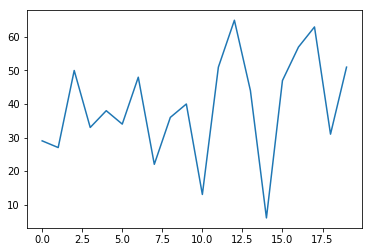

In [15]:
# Set learning parameters
y = .99
e = 0.1
num_episodes = 20
#create lists to contain total rewards and steps per episode
jList = []
rList = []
winList = []
with tf.Session() as sess:
    sess.run(init)
    for i in range(num_episodes):
        #Reset environment and get first new observation
        if i % 10 == 0:
            print("Episode {}".format(i))
        rules = Rules()
        rules.nb_max_step = 100
        rules.nb_players = 10
        game1 = Game()
        game1.rules = rules
        player1 = Player()
        player1.name = "RL"
        player1.rules = rules
        player1.type = EntityType.competitive_player
        game1.add_player(player1)
        
        
        player2 = Player()
        player2.rules = rules
        player2.name = "Heuristic"
        player2.type = EntityType.competitive_player
        strategy_builder = StrategyBuilder()
        player2.strategy = strategy_builder.get_random_egoist_strategy()
        game1.add_player(player2)
        
        game1.initialize_graph()
        
        s = get_game_graph(game1).flatten()
        
        rAll = 0
        previous_centrality = 0
        d = False
        j = 0
        win = 0
        #The Q-Network
        while j < rules.nb_max_step:
            j+=1
            #Choose an action by greedily (with e chance of random action) from the Q-network
            a, allQ = sess.run([predict,Qout],feed_dict={inputs1:s})
            if np.random.rand(1) < e:
                a[0] = np.random.randint(action_space)
            #Get new state and reward from environment
            action = None
            possible_actions = get_actions(game1)
            if a[0] is not 0:
                action = [possible_actions[a[0]]]
            else:
                action = None
            actions = list(game1.get_actions())
            action.extend(actions)
            game1.play_round(actions=action)
            s1 = get_game_graph(game1).flatten()
            centralities = nx.betweenness_centrality(game1.graph)
            centrality = centralities[0]
            leader = max(list(centralities.values()))
            if centrality == leader:
                r = 1
            else:
                r = -1
            """
            if centrality == previous_centrality:
                r = 0
            elif centrality > previous_centrality:
                r = 1
            else:
                r = -1
            """
            #print(centrality, previous_centrality, r)
            #Obtain the Q' values by feeding the new state through our network
            Q1 = sess.run(Qout,feed_dict={inputs1:s1})
            #Obtain maxQ' and set our target value for chosen action.
            maxQ1 = np.max(Q1)
            targetQ = allQ
            targetQ[0,a[0]] = r + y*maxQ1
            #Train our network using target and predicted Q values
            _,W1 = sess.run([updateModel,W],feed_dict={inputs1:s,nextQ:targetQ})
            rAll += r
            s = s1
            previous_centrality = centrality
            
            opponent_centrality = centralities[1]
            if centrality > opponent_centrality:
                win += 1
            if centrality == 1.0 and j > 20:
                #Reduce chance of random action as we train the model.
                e = 1./((i/50) + 10)
                break
        winList.append(win)
        jList.append(j)
        rList.append(rAll)
rList = np.array(rList)
print("Percent of succesful episodes: " + str(np.sum(rList)/num_episodes) + "%")

plt.plot(winList)